In [1]:
import sys

sys.path.append("../berries")


In [2]:
from datasets import load_dataset

mnist = load_dataset("mnist").with_format("jax")
mnistData = mnist['train']
X_img = mnistData['image']
y = mnistData['label']
X_img_test = mnist["test"]["image"]
n_test_samples = X_img_test.shape[0]
X_test = X_img_test.reshape((n_test_samples, -1))
y_test = mnist["test"]["label"]
n_samples, _, _ = X_img.shape
X = X_img.reshape((n_samples, -1))
n_samples, d_x = X.shape
d_y = len(set(y.tolist()))


/home/owner/Projects/picojam/pico/.venv/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
X = X / 255.0
X_test = X_test / 255.0

In [4]:
d_h_layer = 128
d_h = 64
n_layers = 1
d_in = d_x
# d_out = d_y
d_out = d_x
d_vae_h = 64
beta = 50

In [5]:

import nn
import importlib
importlib.reload(nn)
from nn import mglu_net_config, mglu_net
from pf import F, _

from jax.numpy import mean, exp


def vae_config(d_in, d_h_layer, d_vae_h, d_h, n_layers, init):
    return {
        "encoder":mglu_net_config(d_in, d_h_layer, 2 * d_vae_h, d_h, n_layers, init),
        "decoder": mglu_net_config(d_vae_h, d_h_layer, d_in, d_h, n_layers, init)}

def vae(W, x, noise):
    h = mglu_net(x, W["encoder"])
    mu, log_sigma = h[:d_vae_h], h[d_vae_h:]
    z = mu + noise * log_sigma
    xp = mglu_net(z, W["decoder"])
    return xp, mu, log_sigma



def vae_loss(W, x, noise):
    xp, mu, log_sigma = vae(W, x, noise)
    return beta * ((xp - x) ** 2).mean() - 0.5 * (1 + log_sigma - mu ** 2 - exp(log_sigma)).mean()


loss_b = F(vae_loss).vmap((None, 0, 0), 0)
loss_bm = loss_b >> mean

def vae_test_loss(W, x):
    xp, _, _ = vae(W, x, 0)
    return ((xp - x) ** 2).mean()

test_loss_b = F(vae_test_loss).vmap((None, 0), 0)
test_loss_bm = test_loss_b >> mean

vae_b = F(vae).vmap((None, 0, 0), 0)


In [6]:
import optax
from jax import grad, jit
from jax.tree_util import tree_map
import random_utils
import init_utils
from nn import init_weights, fmt_weights

seed = 0
key_gen = random_utils.infinite_safe_keys(seed)



lr = 0.001
mask_fn = lambda p: tree_map(lambda x: not isinstance(x, int), p)
# opt = optax.multi_transform({"sgd": optax.rmsprop(lr), "zero": optax.set_to_zero()}, mask_fn)
opt = optax.masked(optax.rmsprop(lr), mask_fn)

def get_noise(size, key):
    return init_utils.normal_init(key, sd=0.1, shape=[size, d_x])

# method = {"type": "zer0", "std": 0.001}
method = {"type": "normal", "std": 0.01}
# W = init_weights(next(key_gen), mglu_net_config(d_in, d_h_layer, d_out, d_h, n_layers, method))
W = init_weights(next(key_gen), vae_config(d_in, d_h_layer, d_vae_h, d_h, n_layers, method))
loss0 = test_loss_bm(W, X_test)
print(loss0)
print(fmt_weights(W)[0])
state = opt.init(W)

@jit
def update(W, x, noise, opt_state):
    grads = grad(loss_bm)(W, x, noise)
    updates, opt_state = opt.update(grads, opt_state)
    new_W = optax.apply_updates(W, updates)
    return new_W, opt_state

0.11400624
encoder:
    mglu:
        tuple:
            sglu:
                wv:
                    array shape: (784, 64)
                wu:
                    array shape: (784, 64)
                wo:
                    array shape: (64, 128)
                total params: 108544
            rmsn:
                d:
                    128.0
                total params: 1
            total params: 108545
        tuple:
            sglu:
                wv:
                    array shape: (128, 64)
                wu:
                    array shape: (128, 64)
                wo:
                    array shape: (64, 128)
                total params: 24576
            rmsn:
                d:
                    128.0
                total params: 1
            total params: 24577
        total params: 133122
    sglu:
        wv:
            array shape: (128, 64)
        wu:
            array shape: (128, 64)
        wo:
            array shape: (64, 128)
        total para

2.2184112 0.044657055


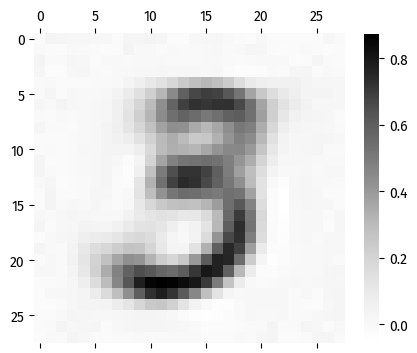

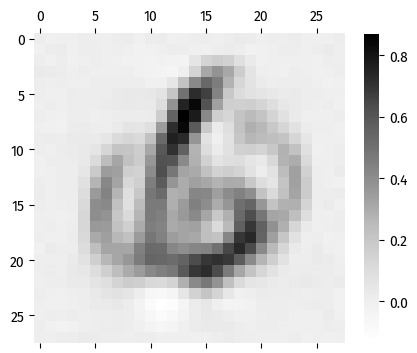

2.086358 0.042952616
2.0555303 0.040563457
1.9572935 0.0394086
1.7904395 0.036461756
1.8108634 0.036314376


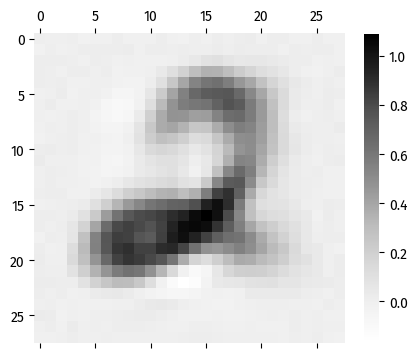

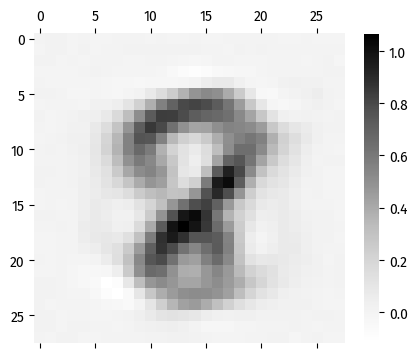

1.6882441 0.034320537
1.6079066 0.032458883
1.5955132 0.032338835
1.5183628 0.031006468
1.5440083 0.031346116


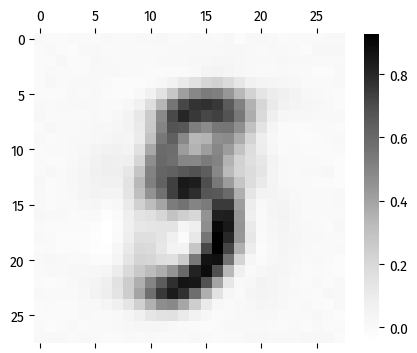

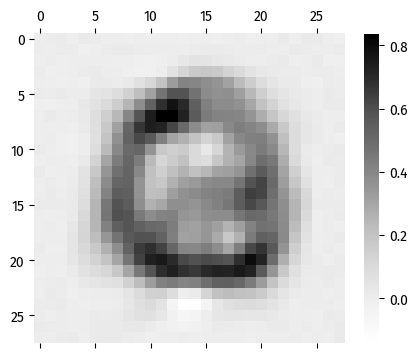

1.5097711 0.03013015
1.4832728 0.030388555
1.4062811 0.028274799
1.4782813 0.03049088
1.3683193 0.027519127


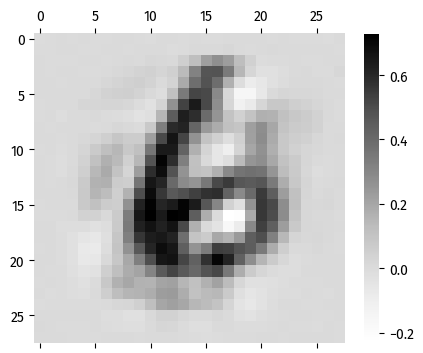

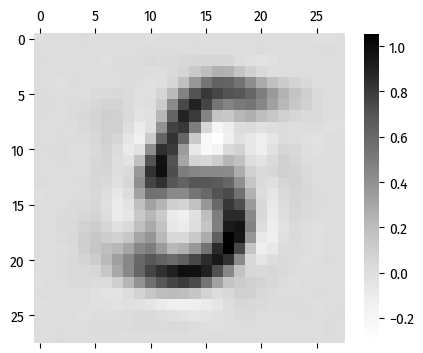

1.3215885 0.027125562
1.3012977 0.026513925
1.3104389 0.026155462
1.3169904 0.02602854
1.2723615 0.026128655


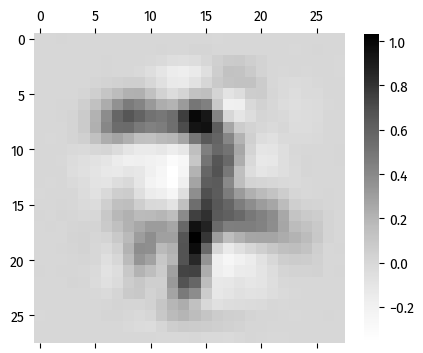

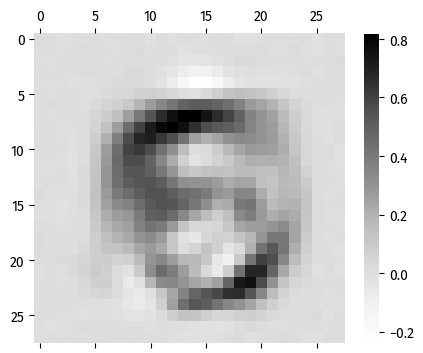

1.2753735 0.025485337
1.3038385 0.0266354
1.180968 0.023992984
1.2512436 0.024887742
0.023385167


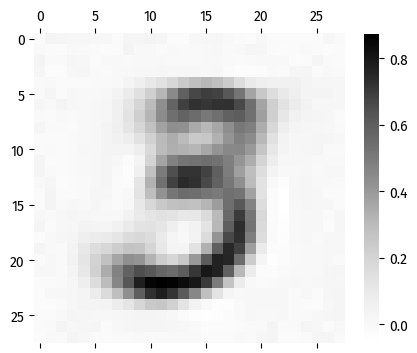

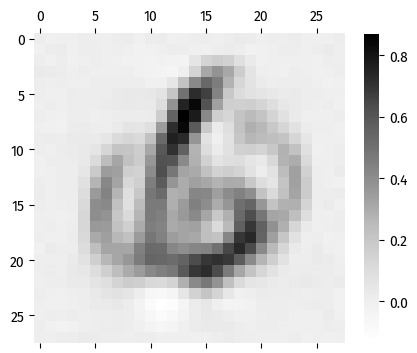

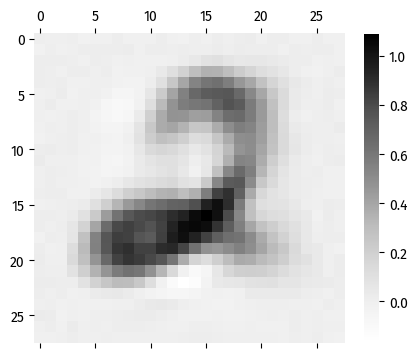

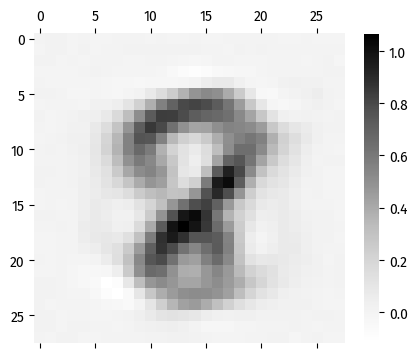

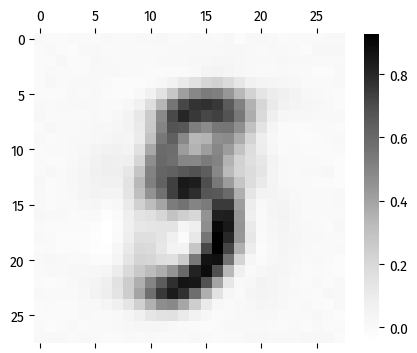

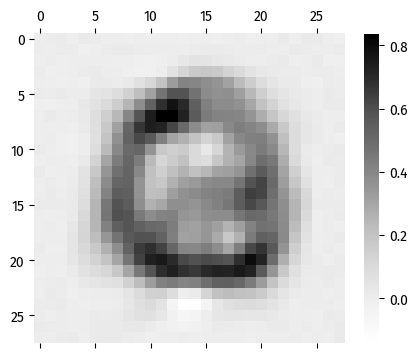

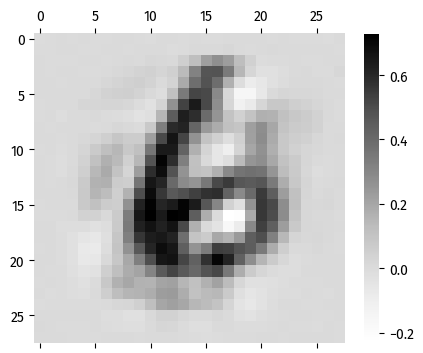

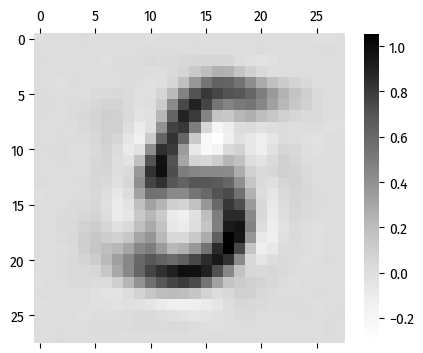

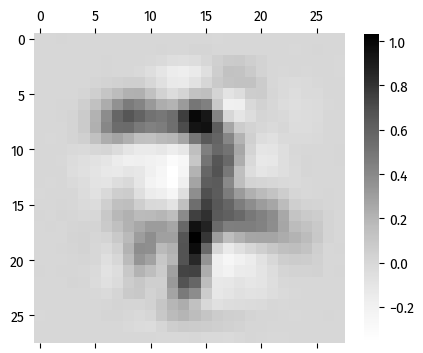

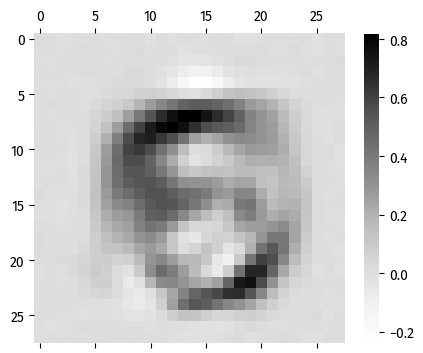

In [46]:
from plot_utils import visualize_matrix
from IPython.display import display
import math, random


loss_dt = test_loss_b.f(_, X_test)
loss_b_dt = loss_dt >> mean

def get_noise(size, key):
    return init_utils.normal_init(key, sd=1, shape=[size, d_vae_h])

batch_size = 1024

def sample():
    return X[random.sample(range(n_samples), batch_size), :]

for i in range(5000):
    key = next(key_gen)
    noise = get_noise(batch_size, key)
    data = sample()
    W, state = update(W, data, noise, state)
    if i % 200 == 0:
        print(loss_bm(W, data, noise), loss_b_dt(W))
    if i % 1000 == 0:
        image_id = math.ceil(random.uniform(0, 1) * n_samples)
        # plt, __, __ = visualize_matrix(X[image_id, :].reshape(28, 28), dpi=100)
        # display(plt)

        # plt, __, __ = visualize_matrix(vae(W, X[image_id, :], noise[image_id, :])[0].reshape(28, 28), dpi=100)
        # display(plt)

        plt, __, __ = visualize_matrix(mglu_net(noise[0, :], W['decoder']).reshape(28, 28), dpi=100)
        display(plt)
        plt, __, __ = visualize_matrix(mglu_net(noise[1, :], W['decoder']).reshape(28, 28), dpi=100)
        display(plt)

print(loss_b_dt(W))
